# Understanding the in-situ Solar Wind Properties with Machine Learning and Artificial Intelligence


Project Abstract: 
With the rapid increase of the in-situ measurements of the solar wind plasma, traditional data analysis methods are no longer sufficient for Heliophysics scientists to fully comprehend the scientific insights embedded within the data. Applications of Machine learning (ML) and Artificial Intelligence (AI) techniques on the solar data in order to perform feature selection, dimension reduction and clustering is the major goal of this proposal.

Project Outcome:
1). The importance ranking of the solar wind input data.
2). Visualization of the solar wind data in 2D, after the dimension reduction.
3). Labels of the clustering.
4). Prediction of the monthly sunspot number and the indexes of the HCS


In [1]:
import pandas as pd
import re
import numpy as np
# from pydantic_settings import BaseSettings #not sure if it's needed
# from ydata_profiling import ProfileReport
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose, DecomposeResult
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

#pip install ydata-profiling
#pip install pydantic-settings 


# Reading Data sources and Performing Exploratory Data Analysis

<h1 style="color: Turquoise;">HCS Indexes</h1>
Heliospheric Current Sheet (HCS) Indexes: two data points per month, in about 30 years.


From Dr. Zhao: "As you can see, there are 13 columns, the data you need are fyear_CS (gives the time as a fractional yea), SD_70 (the SD index), and SL_70 (the SL index, I use log_10 of this index to make it more compatible with SD, but it's up to you)."



<h3 style="color: Turquoise;">Reading HCS Data</h3>

In [2]:
file_path = '../data/HCS_parameters_update_CR2257.txt'

with open(file_path, 'r') as file:
    # Read the headers
    headers = file.readline().strip().split(',')
    
    # Initialize a list to hold all rows of data
    data = []
    
    # Read each subsequent line
    for line in file:
        # Split the line by one or more spaces
        row_values = re.split(r'\s+', line.strip())
        
        # Check if row_values matches the number of headers to avoid errors
        if len(row_values) == len(headers):
            # Create a dictionary for the current row
            row_dict = dict(zip(headers, row_values))
            # Append the dictionary to the data list
            data.append(row_dict)

# Convert the list of dictionaries into a DataFrame
hcs = pd.DataFrame(data)
hcs = hcs.apply(pd.to_numeric, errors='coerce')


hcs.head()

,cr_temp,fyear_CS,sddv_CS,SD_70,SD_70_north,SD_70_south,slop_CS,SL_70,SL_70_north,SL_70_south,ave_slop_CS,HCS_length,HCS_area
0,1642,1976.439331,4.432569,4.432569,3.818581,5.047269,26.940952,26.940952,14.503848,10.741140,0.277742,91.690765,382.107880
1,1643,1976.513672,4.316492,4.316492,4.046187,4.617753,20.119915,20.119915,11.341628,7.920633,0.223555,72.286812,318.171631
2,1644,1976.588013,7.398017,7.398017,8.212896,4.084693,22.928347,22.928347,15.639559,6.637887,0.246541,82.871422,360.902832
3,1645,1976.662354,4.060399,4.060399,3.235534,4.961203,21.927540,21.927540,10.686832,9.583878,0.240962,78.850441,341.176422
4,1646,1976.736816,4.522666,4.522666,4.177734,5.022253,24.674475,24.674475,12.996892,9.839160,0.265317,85.188026,353.769745


<h3 style="color: Turquoise;"> HCS Exploratory Data Analysis</h3>

In [3]:
print('HCS indexes size:',hcs.shape)

HCS indexes size: (596, 13)


In [4]:
# Basic Information
print("Basic DataFrame information:")
print(hcs.info())

Basic DataFrame information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 596 entries, 0 to 595
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   cr_temp      596 non-null    int64  
 1   fyear_CS     596 non-null    float64
 2   sddv_CS      596 non-null    float64
 3   SD_70        596 non-null    float64
 4   SD_70_north  596 non-null    float64
 5   SD_70_south  596 non-null    float64
 6   slop_CS      596 non-null    float64
 7   SL_70        596 non-null    float64
 8   SL_70_north  596 non-null    float64
 9   SL_70_south  596 non-null    float64
 10  ave_slop_CS  596 non-null    float64
 11  HCS_length   596 non-null    float64
 12  HCS_area     596 non-null    float64
dtypes: float64(12), int64(1)
memory usage: 60.7 KB
None


All columns seem numerical, so they were all converted.

In [5]:
# Descriptive Statistics
print("\nDescriptive Statistics:")
hcs.describe()


Descriptive Statistics:


,cr_temp,fyear_CS,sddv_CS,SD_70,SD_70_north,SD_70_south,slop_CS,SL_70,SL_70_north,SL_70_south,ave_slop_CS,HCS_length,HCS_area
count,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000
mean,1950.058725,1999.443273,13.170383,12.848655,12.220444,12.720714,389.317071,383.950197,206.815055,149.399131,2.656374,224.394253,886.252966
std,177.584497,13.261180,5.975380,5.534757,6.079613,5.775435,732.429658,724.682166,498.292707,318.546021,4.481671,119.642759,1326.617525
min,1642.000000,1976.439331,1.841347,1.841347,1.345982,1.344595,7.089793,7.089793,2.758448,2.867834,0.089744,31.224827,148.888626
25%,1796.750000,1987.995819,8.033573,8.033573,6.809344,8.179713,44.995888,44.995888,19.768578,23.114806,0.437211,122.412815,448.658364
50%,1948.500000,1999.327880,12.582106,12.582106,11.920234,12.775250,150.608170,150.608170,64.236381,63.124910,1.130784,214.022026,584.331970
75%,2099.250000,2010.584168,18.507510,18.064053,17.841737,17.505987,446.335632,442.458168,185.158127,167.291545,3.051182,298.862778,719.399856
max,2257.000000,2022.364380,24.494244,22.579355,25.071970,24.830502,8278.967773,8274.589844,7159.270508,5260.224121,44.751179,608.842957,9568.851563


In [6]:
# Missing Values Analysis
print("\nMissing Values:")
print(hcs.isnull().sum())


Missing Values:
cr_temp        0
fyear_CS       0
sddv_CS        0
SD_70          0
SD_70_north    0
SD_70_south    0
slop_CS        0
SL_70          0
SL_70_north    0
SL_70_south    0
ave_slop_CS    0
HCS_length     0
HCS_area       0
dtype: int64


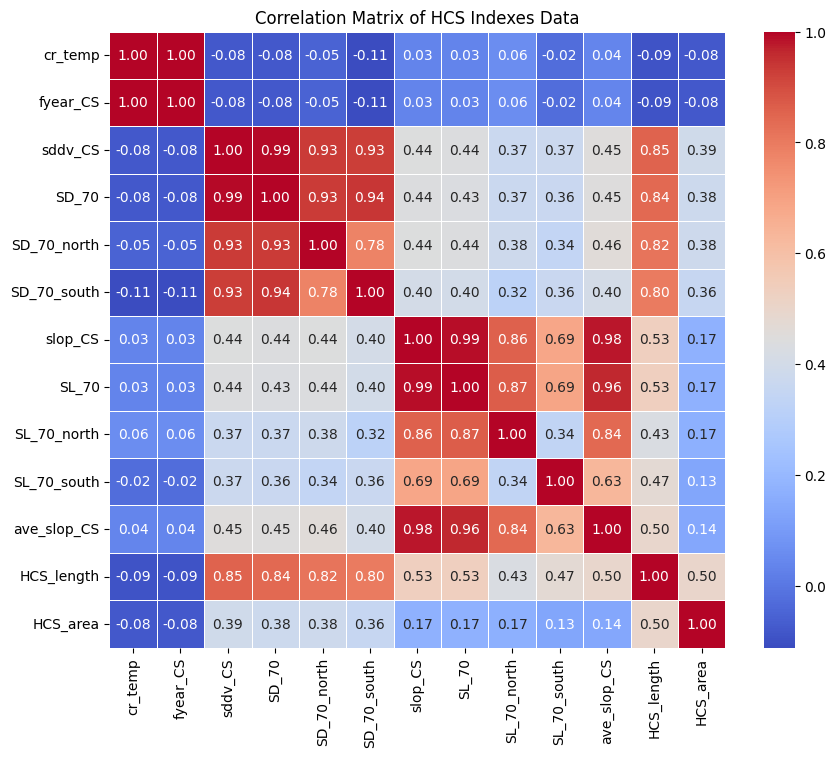

In [7]:
%matplotlib inline

corr_matrix = hcs.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            cbar=True, square=True, linewidths=.5)
            
plt.title('Correlation Matrix of HCS Indexes Data')
plt.show()

Per Dr. Zhao, the outcome variables to explore are SD_70 & SL_70. The other fields shouldn't be used as features for the forecast model becuase they are either dervided from these, or not studeied enough to feel confident in using them.

<h3 style="color: Turquoise;"> HCS Pandas Profile</h3>

In [8]:
# profile = ProfileReport(hcs, title='HCS Pandas Profiling Report', explorative=True)
# profile.to_file("../data/HCS Report.html")

<h3 style="color: Turquoise;"> Filtering columns and adding date columns</h3>

In [9]:
hcs_cleaned = hcs[['fyear_CS', 'SD_70', 'SL_70']].copy()
hcs_cleaned['SL_70_log10'] = np.log10(hcs_cleaned['SL_70'])

hcs_cleaned.head()

,fyear_CS,SD_70,SL_70,SL_70_log10
0,1976.439331,4.432569,26.940952,1.430413
1,1976.513672,4.316492,20.119915,1.303626
2,1976.588013,7.398017,22.928347,1.360373
3,1976.662354,4.060399,21.927540,1.340990
4,1976.736816,4.522666,24.674475,1.392248


In [10]:
#Converting fractional year to date

def fractional_date_to_actual_date(fractional_date):
    year = int(fractional_date)
    remainder = fractional_date - year
    start_of_year = datetime(year, 1, 1)
    days_in_year = 365 + (1 if year % 4 == 0 and (year % 100 != 0 or year % 400 == 0) else 0)
    days_passed = remainder * days_in_year
    actual_date = start_of_year + timedelta(days=days_passed)
    return actual_date.date()

# Apply the conversion function
hcs_cleaned['actual_date'] = pd.to_datetime(hcs_cleaned['fyear_CS'].apply(fractional_date_to_actual_date))

#Getting date parts
hcs_cleaned['year'] = hcs_cleaned['actual_date'].dt.year
hcs_cleaned['month'] = hcs_cleaned['actual_date'].dt.month
hcs_cleaned['day'] = hcs_cleaned['actual_date'].dt.day

#This is to figure out gaps
hcs_cleaned['days_diff'] = hcs_cleaned['actual_date'].diff().dt.days
hcs_cleaned['f_diff'] = hcs_cleaned['fyear_CS'].diff()

hcs_cleaned.head(10)

,fyear_CS,SD_70,SL_70,SL_70_log10,actual_date,year,month,day,days_diff,f_diff
0,1976.439331,4.432569,26.940952,1.430413,1976-06-09,1976,6,9,NaN,NaN
1,1976.513672,4.316492,20.119915,1.303626,1976-07-07,1976,7,7,28.0,0.074341
2,1976.588013,7.398017,22.928347,1.360373,1976-08-03,1976,8,3,27.0,0.074341
3,1976.662354,4.060399,21.927540,1.340990,1976-08-30,1976,8,30,27.0,0.074341
4,1976.736816,4.522666,24.674475,1.392248,1976-09-26,1976,9,26,27.0,0.074462
5,1976.811401,4.935369,30.268057,1.480985,1976-10-23,1976,10,23,27.0,0.074585
6,1976.885864,4.084423,24.410540,1.387577,1976-11-20,1976,11,20,28.0,0.074463
7,1976.960571,5.325225,30.787935,1.488381,1976-12-17,1976,12,17,27.0,0.074707
8,1977.035156,5.392840,26.913641,1.429972,1977-01-13,1977,1,13,27.0,0.074585
9,1977.110107,5.134246,35.899826,1.555092,1977-02-10,1977,2,10,28.0,0.074951


<h3 style="color: Turquoise;"> Identifying gaps</h3>

size (17, 10)


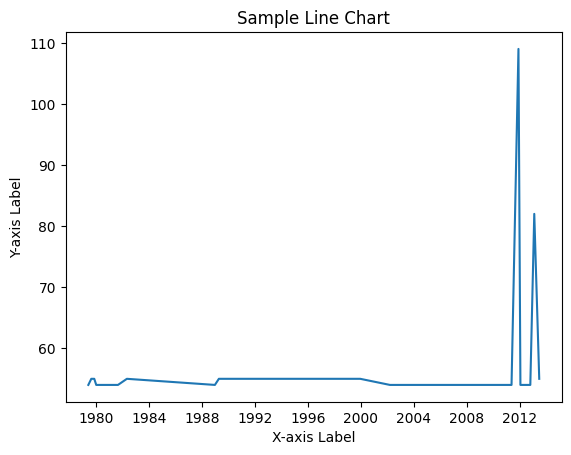

In [11]:
# Filtering for gaps that are bigger than a Carrington Rotation
%matplotlib inline
hcs_filtered = hcs_cleaned.loc[hcs_cleaned['days_diff']>28]
print('size', hcs_filtered.shape)
x = hcs_filtered['actual_date']
y = hcs_filtered['days_diff']

plt.plot(x, y) # Plot the line chart

# Adding title and labels
plt.title('Sample Line Chart')
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')

# Display the chart
plt.show()

In [12]:
#Getting the gaps
gaps = hcs_cleaned.loc[hcs_cleaned['days_diff']>28].copy()
gaps['periods_missing'] = round(gaps['days_diff']/27,0)
gaps['from_date'] = gaps['actual_date'] - pd.to_timedelta(gaps['days_diff'], unit='D')
gaps

,fyear_CS,SD_70,SL_70,SL_70_log10,actual_date,year,month,day,days_diff,f_diff,periods_missing,from_date
39,1979.426758,19.940844,1194.637939,3.077236,1979-06-05,1979,6,5,54.0,0.149292,2.0,1979-04-12
41,1979.650391,20.999605,652.765686,2.814757,1979-08-26,1979,8,26,55.0,0.149048,2.0,1979-07-02
43,1979.874512,19.422478,456.891846,2.659813,1979-11-16,1979,11,16,55.0,0.149414,2.0,1979-09-22
44,1980.024292,20.678894,1091.813721,3.038149,1980-01-09,1980,1,9,54.0,0.149780,2.0,1979-11-16
65,1981.665283,16.226286,1021.938660,3.009425,1981-08-31,1981,8,31,54.0,0.149170,2.0,1981-07-08
73,1982.338501,16.791019,106.547760,2.027544,1982-05-04,1982,5,4,55.0,0.149536,2.0,1982-03-10
161,1988.983276,17.304764,569.275269,2.755322,1988-12-25,1988,12,25,54.0,0.149170,2.0,1988-11-01
164,1989.282593,18.411699,711.666138,2.852276,1989-04-14,1989,4,14,55.0,0.149658,2.0,1989-02-18
171,1989.879761,19.345488,442.361450,2.645777,1989-11-18,1989,11,18,55.0,0.149536,2.0,1989-09-24
305,1999.962402,21.256525,1392.705444,3.143859,1999-12-18,1999,12,18,55.0,0.149536,2.0,1999-10-24


<h3 style="color: Turquoise;"> Creating a clean dataframe with continues Carrington Rotations to join to HCS</h3>

In [13]:
def fractional_year_to_datetime(fractional_year):
    """Convert a fractional year to a datetime object."""
    year = int(fractional_year)
    remainder = fractional_year - year
    if (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0):
        days_in_year = 366
    else:
        days_in_year = 365
    day_of_year = int(remainder * days_in_year) + 1
    date = datetime(year, 1, 1) + timedelta(days=day_of_year - 1)
    return date

# Extracting renage of dates represented in the HCS data
start_fractional_year = hcs['fyear_CS'].min()
end_fractional_year = hcs['fyear_CS'].max() + (27.2753 / 365.25)  

# Interval in days for Carrington rotation
interval_days = 27.2753

# Calculate the updated number of intervals
total_days_updated = (end_fractional_year - start_fractional_year) * 365.25
num_intervals_updated = int(total_days_updated / interval_days)

# Generate the dates, fractional years, and incremental numbers
fractional_years_updated = [start_fractional_year + (i * interval_days / 365.25) for i in range(num_intervals_updated + 1)]
dates_updated = [fractional_year_to_datetime(fy) for fy in fractional_years_updated]

incremental_numbers = list(range(hcs['cr_temp'].min(), hcs['cr_temp'].min() + len(dates_updated)))

# Create the updated DataFrame with additional columns
cr = pd.DataFrame({
    "Date": dates_updated,
    "Fractional_Year": fractional_years_updated,
    "Incremental_Number": incremental_numbers
})

cr['year_cr'] = cr['Date'].dt.year
cr['month_cr'] = cr['Date'].dt.month
cr['day_cr'] = cr['Date'].dt.day

# Display the DataFrame
print(cr.head(10))


        Date  Fractional_Year  Incremental_Number  year_cr  month_cr  day_cr
0 1976-06-09      1976.439331                1642     1976         6       9
1 1976-07-07      1976.514007                1643     1976         7       7
2 1976-08-03      1976.588682                1644     1976         8       3
3 1976-08-30      1976.663358                1645     1976         8      30
4 1976-09-27      1976.738034                1646     1976         9      27
5 1976-10-24      1976.812710                1647     1976        10      24
6 1976-11-20      1976.887385                1648     1976        11      20
7 1976-12-18      1976.962061                1649     1976        12      18
8 1977-01-14      1977.036737                1650     1977         1      14
9 1977-02-10      1977.111412                1651     1977         2      10


<h3 style="color: Turquoise;"> Joining this df to HCS</h3>

This didn't work because HCS data was rounded up to 28 in some cases

In [14]:
hcs_merged = pd.merge(cr , hcs_cleaned, how= 'left', left_on= 'Date', right_on= 'actual_date')
hcs_merged.head()

,Date,Fractional_Year,Incremental_Number,year_cr,month_cr,day_cr,fyear_CS,SD_70,SL_70,SL_70_log10,actual_date,year,month,day,days_diff,f_diff
0,1976-06-09,1976.439331,1642,1976,6,9,1976.439331,4.432569,26.940952,1.430413,1976-06-09,1976.0,6.0,9.0,NaN,NaN
1,1976-07-07,1976.514007,1643,1976,7,7,1976.513672,4.316492,20.119915,1.303626,1976-07-07,1976.0,7.0,7.0,28.0,0.074341
2,1976-08-03,1976.588682,1644,1976,8,3,1976.588013,7.398017,22.928347,1.360373,1976-08-03,1976.0,8.0,3.0,27.0,0.074341
3,1976-08-30,1976.663358,1645,1976,8,30,1976.662354,4.060399,21.927540,1.340990,1976-08-30,1976.0,8.0,30.0,27.0,0.074341
4,1976-09-27,1976.738034,1646,1976,9,27,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN


<h3 style="color: Turquoise;"> Testing another alternative by finding the nearest date</h3>

In [15]:
def find_nearest_date(row):
    # Compute the absolute difference between the current date in hcs_df and all dates in cr
    diff = cr['Date'] - row['actual_date']
    # Find the index of the minimum absolute difference
    idx_min = diff.abs().idxmin()
    # Return the date from cr that corresponds to this index
    return cr.loc[idx_min, 'Date']

# Apply the function to hcs_df to create a new column with the nearest date from cr
hcs_cleaned['nearest_Date'] = hcs_cleaned.apply(find_nearest_date, axis=1)

# Merge cr and hcs_df based on the nearest date found
result_df = pd.merge(cr, hcs_cleaned, left_on='Date', right_on='nearest_Date', how='left')

# Drop the 'nearest_Date' column if it's no longer needed
result_df.drop('nearest_Date', axis=1, inplace=True)

result_df['fyear_CS'] = result_df['fyear_CS'].fillna(result_df['Fractional_Year'])
result_df['actual_date'] = result_df['actual_date'].fillna(result_df['Date'])

result_df['year'] = result_df['year_cr'].fillna(result_df['Date'])
result_df['month'] = result_df['month_cr'].fillna(result_df['Date'])
result_df['day'] = result_df['day_cr'].fillna(result_df['Date'])
result_df['from_date'] = result_df['actual_date']


In [16]:
hcs_df = result_df[['fyear_CS','SD_70','SL_70','SL_70_log10','actual_date','year','month','day', 'from_date']].copy()
hcs_df.head()

,fyear_CS,SD_70,SL_70,SL_70_log10,actual_date,year,month,day,from_date
0,1976.439331,4.432569,26.940952,1.430413,1976-06-09,1976,6,9,1976-06-09
1,1976.513672,4.316492,20.119915,1.303626,1976-07-07,1976,7,7,1976-07-07
2,1976.588013,7.398017,22.928347,1.360373,1976-08-03,1976,8,3,1976-08-03
3,1976.662354,4.060399,21.927540,1.340990,1976-08-30,1976,8,30,1976-08-30
4,1976.736816,4.522666,24.674475,1.392248,1976-09-26,1976,9,27,1976-09-26


In [17]:
#output HCS

hcs_df.to_csv('../data/HCS Cleaned.csv', index=False)  

<h1 style="color: gold;"> Sunspot Number</h1>

https://www.sidc.be/SILSO/infosnmtot

Format: plain ASCII text

Contents:
Column 1-2: Gregorian calendar date
- Year
- Month
Column 3: Date in fraction of year for the middle of the corresponding month
Column 4: Monthly mean total sunspot number.
Column 5: Monthly mean standard deviation of the input sunspot numbers from individual stations.
Column 6: Number of observations used to compute the monthly mean total sunspot number.
Column 7: Definitive/provisional marker. A blank indicates that the value is definitive. A '*' symbol indicates that the monthly value is still provisional and is subject to a possible revision (Usually the last 3 to 6 months)

Line format [character position]:
- [1-4] Year
- [6-7] Month
- [9-16] Decimal date
- [19-23] Monthly total sunspot number
- [25-29] Standard deviation
- [32-35] Number of observations
- [37] Definitive/provisional indicator

<h3 style="color: gold;">Reading Sunspot Data</h3>

In [18]:
file_path = '../data/Sunspot Number NASA.txt'

with open(file_path, 'r') as file:
    # Set header
    headers = ['year', 'month', 'fyear_CS', 'monthly_sunspots', 'std', 'observations']
    
    # Initialize a list to hold all rows of data
    data = []
    
    # Read each subsequent line
    for line in file:
        # Split the line by one or more spaces
        row_values = re.split(r'\s+', line.strip())
        
        # Check if row_values matches the number of headers to avoid errors
        if len(row_values) == len(headers):
            # Create a dictionary for the current row
            row_dict = dict(zip(headers, row_values))
            # Append the dictionary to the data list
            data.append(row_dict)

# Convert the list of dictionaries into a DataFrame
sunspots = pd.DataFrame(data)

sunspots = sunspots.apply(pd.to_numeric, errors='coerce')

sunspots.head()

,year,month,fyear_CS,monthly_sunspots,std,observations
0,1749,1,1749.042,96.7,-1.0,-1
1,1749,2,1749.123,104.3,-1.0,-1
2,1749,3,1749.204,116.7,-1.0,-1
3,1749,4,1749.288,92.8,-1.0,-1
4,1749,5,1749.371,141.7,-1.0,-1


In [19]:
sunspots.columns

Index(['year', 'month', 'fyear_CS', 'monthly_sunspots', 'std', 'observations'], dtype='object')

<h3 style="color: gold;">Sunspots Exploratory Data Analysis</h3>

In [20]:
print('Sunspots data size:',sunspots.shape)

Sunspots data size: (3207, 6)


In [46]:
print('Min Year:',sunspots['year'].min())
print('Max Year:',sunspots['year'].max())

Min Year: 1749
Max Year: 2016


In [22]:
sunspots.describe()

,year,month,fyear_CS,monthly_sunspots,std,observations
count,3207.000000,3207.000000,3207.000000,3207.000000,3207.000000,3207.000000
mean,1882.125351,6.495790,1882.623011,83.004210,5.614531,88.390708
std,77.160529,3.453808,77.160463,67.855556,5.238495,182.586154
min,1749.000000,1.000000,1749.042000,0.000000,-1.000000,-1.000000
25%,1815.000000,3.000000,1815.832000,25.300000,-1.000000,-1.000000
50%,1882.000000,6.000000,1882.623000,69.800000,5.400000,30.000000
75%,1949.000000,9.000000,1949.413000,123.900000,9.400000,31.000000
max,2016.000000,12.000000,2016.206000,398.200000,23.500000,977.000000


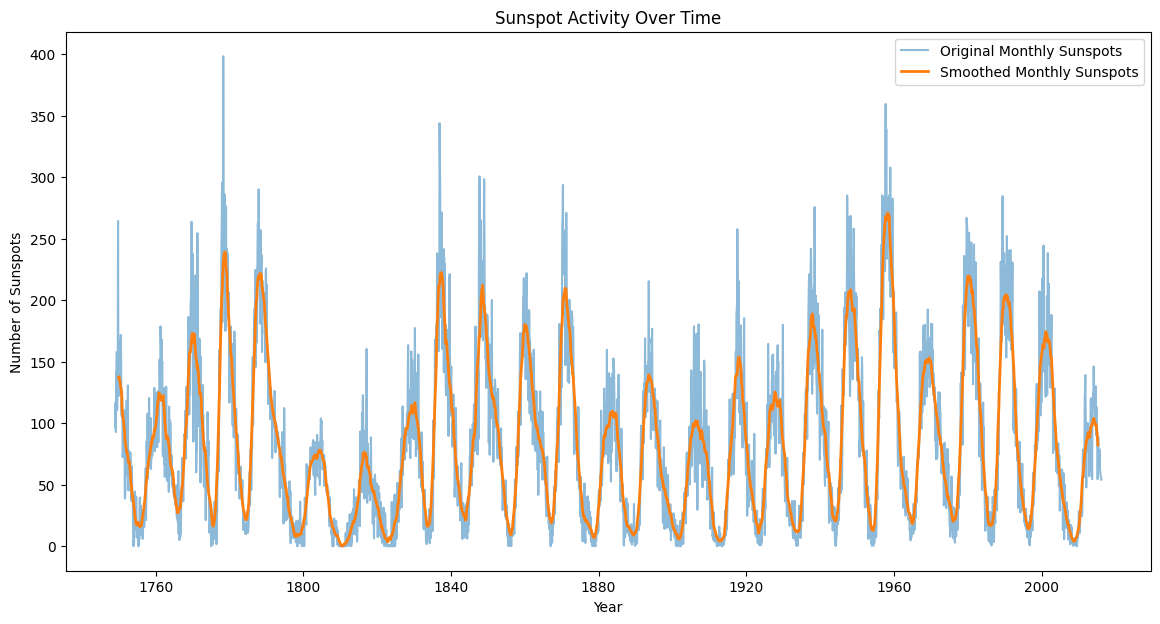

In [44]:
# Smoothing out the data to 
sunspots['date'] = pd.to_datetime(sunspots[['year', 'month']].assign(DAY=1))
sunspots['smoothed_sunspots'] = sunspots['monthly_sunspots'].rolling(window=24, center=True).mean()
plt.figure(figsize=(14, 7))
plt.plot(sunspots['date'], sunspots['monthly_sunspots'], label='Original Monthly Sunspots', alpha=0.5)
plt.plot(sunspots['date'], sunspots['smoothed_sunspots'], label='Smoothed Monthly Sunspots', linewidth=2)
plt.title('Sunspot Activity Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Sunspots')
plt.legend()
plt.show()


<h3 style="color: gold;">Sunspots Pandas profiling</h3>

In [26]:
# profile_sun = ProfileReport(sunspots, title='Sunspots Pandas Profiling Report', explorative=True)
# profile_sun.to_file("../data/Sunsports Report.html")

<h1 style="color: Magenta;">ACE Mission Data</h1>
https://izw1.caltech.edu/ACE/ASC/level2/lvl2DATA_SWEPAM.html

SWEPAM Hourly Averaged Solar Wind Parameters  
Data downloaded from ACE Science Center on Wed Feb 28 21:20:51 2024  
SWEPAM Team Software Version: 3.30  
SWEPAM Team Time/Date Processed:   
ACE Science Center Level2 Software Version: 1.5  
ACE Science Center Processing Date/Time: Fri Nov 24 11:12:58 2023 PST  
  
  
Note: All timestamps are UT, and refer to the start of the time period.  
year,day,hr,min,sec: year, day of year, hour of day, minutes, seconds.  
- fp_year       : fractional year.  
- fp_doy        : fractional day-of-year.  
- ACEepoch      : seconds since Jan 1 00:00:00 UT 1996.  
- proton_density: Proton Density (cm^-3).  
- proton_temp   : Radial Component of proton temperature (deg. Kelvin).  
- He4toprotons  : Ratio of alphas/protons  
- proton_speed  : Proton Speed (km/s)  
- x,y,z_dot_GSE : X,Y,Z-component of proton velocity in GSE coordinates (km/s)  
- r,t,n_dot_RTN : R,T,N-component of proton velocity in RTN coordinates (km/s)  
- x,y,z_dot_GSM : X,Y,Z-component of proton velocity in GSM coordinates (km/s)  
- Electron_temp : Electron Temperature (deg. Kelvin).  
- pos_gse_x,y,z : Components of spacecraft position in GSE (km).  
- pos_gsm_x,y,z : Components of spacecraft position in GSM (km).  
- A value of -9999.9 indicates bad or missing data.  
  
More Documentation of the ACE SWEPAM level 2 data is at this web site:  
http://www.srl.caltech.edu/ACE/ASC/level2/swepam_l2desc.html  


<h3 style="color: magenta;">Reading ACE data</h3>

Exploratory data analysis performed on another notebook

In [27]:
file_path = '../data/ACE_Level2_Hourly'

ace_hourly = pd.read_csv(file_path, sep="\s+")
ace_hourly.head()


,year,day,hr,min,sec,fp_year,fp_doy,ACEepoch,proton_density,proton_temp,...,pos_gsm_z,Electron_temp,fraction_time_proton_density,fraction_time_proton_temp,fraction_time_He4toprotons,fraction_time_proton_speed,fraction_time_dot_GSE,fraction_time_dot_RTN,fraction_time_Electron_temp,weight
0,1998,23,0,0,0.0,1998.060274,23.000000,65059200.0,-9999.9,-9999.9,...,166800.0,-10000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1998,23,1,0,0.0,1998.060388,23.041667,65062800.0,-9999.9,-9999.9,...,162650.0,-10000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,1998,23,2,0,0.0,1998.060502,23.083333,65066400.0,-9999.9,-9999.9,...,156070.0,-10000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,1998,23,3,0,0.0,1998.060616,23.125000,65070000.0,-9999.9,-9999.9,...,147290.0,-10000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,1998,23,4,0,0.0,1998.060731,23.166667,65073600.0,-9999.9,-9999.9,...,136820.0,-10000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [28]:
print('ACE Level 2 Hourly data size:',ace_hourly.shape)

ACE Level 2 Hourly data size: (204768, 36)


In [29]:
ace_hourly.describe()

,year,day,hr,min,sec,fp_year,fp_doy,ACEepoch,proton_density,proton_temp,...,pos_gsm_z,Electron_temp,fraction_time_proton_density,fraction_time_proton_temp,fraction_time_He4toprotons,fraction_time_proton_speed,fraction_time_dot_GSE,fraction_time_dot_RTN,fraction_time_Electron_temp,weight
count,204768.000000,204768.000000,204768.000000,204768.0,204768.0,204768.000000,204768.000000,2.047680e+05,204768.000000,2.047680e+05,...,204768.000000,204768.0,204768.000000,204768.000000,204768.000000,204768.000000,204768.000000,204768.000000,204768.0,204768.000000
mean,2009.244257,181.670066,11.500000,0.0,0.0,2009.740204,182.149232,4.336398e+08,-3583.192620,7.729277e+04,...,3640.350963,-10000.0,0.580415,0.799835,0.518758,0.931895,0.930986,0.930986,0.0,32.649042
std,6.748173,105.385458,6.922203,0.0,0.0,6.743248,105.385853,2.128017e+08,4798.960802,7.644430e+04,...,115468.042694,0.0,0.450590,0.333071,0.448238,0.130196,0.131082,0.131082,0.0,25.348204
min,1998.000000,1.000000,0.000000,0.0,0.0,1998.060274,1.000000,6.505920e+07,-9999.900000,-9.999900e+03,...,-265280.000000,-10000.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,2003.000000,90.000000,5.750000,0.0,0.0,2003.901341,90.781250,2.493495e+08,-9999.900000,2.743475e+04,...,-87177.000000,-10000.0,0.000000,0.892900,0.000000,0.946400,0.946400,0.946400,0.0,0.000000
50%,2009.000000,180.000000,11.500000,0.0,0.0,2009.739669,180.750000,4.336398e+08,2.873000,5.912100e+04,...,9371.950000,-10000.0,0.912300,0.947400,0.789500,0.964300,0.964300,0.964300,0.0,52.000000
75%,2015.000000,273.000000,17.250000,0.0,0.0,2015.580736,273.500000,6.179301e+08,5.424000,1.105325e+05,...,104800.000000,-10000.0,0.964300,0.964300,0.946400,0.964300,0.964300,0.964300,0.0,54.000000
max,2021.000000,366.000000,23.000000,0.0,0.0,2021.419064,366.958333,8.022204e+08,104.335000,1.156600e+06,...,241120.000000,-10000.0,0.982500,0.982500,0.982500,0.982500,0.982500,0.982500,0.0,56.000000


<h3 style="color: magenta;">ACE Data Pandas profiling</h3>

In [30]:
# profile_ace = ProfileReport(ace_hourly, title='ACE Hourly Pandas Profiling Report', explorative=True)
# profile_ace.to_file("../dta/ACE Hourly Report.html")

<h3 style="color: magenta;">Clean ACE Mission Data</h3>

Provided from another notebook

In [31]:
#Should we add code here
file_path = '../assets/ACE Mission Cleaned.csv'
ace_hourly_cleaned = pd.read_csv(file_path)
ace_hourly_cleaned.head()


,fp_year,fp_doy,proton_density,proton_temp,He4toprotons,proton_speed
0,1998.095890,36.000000,16.655,9529.1,0.0127,323.90
1,1998.096005,36.041667,20.601,8757.7,0.0141,322.89
2,1998.096119,36.083333,18.679,9559.4,0.0087,324.61
3,1998.096233,36.125000,18.481,8965.9,0.0051,322.68
4,1998.096347,36.166667,28.315,8329.0,0.0061,321.84


In [32]:
#Getting the month and year
ace_hourly_cleaned['actual_date'] = pd.to_datetime(ace_hourly_cleaned['fp_year'].apply(fractional_date_to_actual_date))
ace_hourly_cleaned['year'] = ace_hourly_cleaned['actual_date'].dt.year
ace_hourly_cleaned['month'] = ace_hourly_cleaned['actual_date'].dt.month
ace_hourly_cleaned.head()

,fp_year,fp_doy,proton_density,proton_temp,He4toprotons,proton_speed,actual_date,year,month
0,1998.095890,36.000000,16.655,9529.1,0.0127,323.90,1998-02-04,1998,2
1,1998.096005,36.041667,20.601,8757.7,0.0141,322.89,1998-02-05,1998,2
2,1998.096119,36.083333,18.679,9559.4,0.0087,324.61,1998-02-05,1998,2
3,1998.096233,36.125000,18.481,8965.9,0.0051,322.68,1998-02-05,1998,2
4,1998.096347,36.166667,28.315,8329.0,0.0061,321.84,1998-02-05,1998,2


In [33]:
#Importing file with PCA
ace_pca = pd.read_csv('../data/ACE_Mission_PCA.csv')
ace_pca.head()

,fp_year,fp_doy,proton_density,proton_temp,He4toprotons,proton_speed,PC1,PC2
0,1998.095890,36.000000,16.655,9529.1,0.0127,323.90,-2.488987,-1.529426
1,1998.096005,36.041667,20.601,8757.7,0.0141,322.89,-2.818979,-1.740908
2,1998.096119,36.083333,18.679,9559.4,0.0087,324.61,-2.625311,-1.846591
3,1998.096233,36.125000,18.481,8965.9,0.0051,322.68,-2.613394,-1.992733
4,1998.096347,36.166667,28.315,8329.0,0.0061,321.84,-3.401135,-2.631275


In [34]:
ace_merged = pd.merge(ace_hourly_cleaned, ace_pca[['fp_year','PC1','PC2']], on = 'fp_year', how = 'inner')
ace_merged.head()

,fp_year,fp_doy,proton_density,proton_temp,He4toprotons,proton_speed,actual_date,year,month,PC1,PC2
0,1998.095890,36.000000,16.655,9529.1,0.0127,323.90,1998-02-04,1998,2,-2.488987,-1.529426
1,1998.096005,36.041667,20.601,8757.7,0.0141,322.89,1998-02-05,1998,2,-2.818979,-1.740908
2,1998.096119,36.083333,18.679,9559.4,0.0087,324.61,1998-02-05,1998,2,-2.625311,-1.846591
3,1998.096233,36.125000,18.481,8965.9,0.0051,322.68,1998-02-05,1998,2,-2.613394,-1.992733
4,1998.096347,36.166667,28.315,8329.0,0.0061,321.84,1998-02-05,1998,2,-3.401135,-2.631275


In [35]:
#Note , should I aver PCA?
#Grouping to the month to make it more compatible
ace_grouped = ace_merged.groupby(['year', 'month']).agg({
    'proton_density': 'mean',
    'proton_temp': 'mean',
    'He4toprotons': 'mean',
    'proton_speed': 'mean',
    'PC1':'mean',
    'PC2':'mean'
}).reset_index()

ace_grouped.head()

,year,month,proton_density,proton_temp,He4toprotons,proton_speed,PC1,PC2
0,1998,2,10.668186,55818.621443,0.022320,377.004722,-1.249865,-0.740865
1,1998,3,9.296941,71053.688126,0.030932,402.813548,-0.854332,-0.273900
2,1998,4,8.991568,71262.155483,0.037028,379.456547,-1.017707,-0.005488
3,1998,5,6.943908,100056.671947,0.031098,452.484785,-0.047913,-0.120904
4,1998,6,8.368127,69987.706731,0.024842,414.453910,-0.684110,-0.465511


### Join HCS to Sunspots

Since sunspots is monthly, we averaged the HCS indeces by month to make it compatible

In [36]:
hcs_grouped = hcs_df.groupby(['year', 'month']).agg({
    'SD_70': 'mean',
    'SL_70': 'mean',
    'SL_70_log10': 'mean'
}).reset_index()

hcs_grouped

,year,month,SD_70,SL_70,SL_70_log10
0,1976,6,4.432569,26.940952,1.430413
1,1976,7,4.316492,20.119915,1.303626
2,1976,8,5.729208,22.427943,1.350681
3,1976,9,4.522666,24.674475,1.392248
4,1976,10,4.935369,30.268057,1.480985
...,...,...,...,...,...
547,2022,1,15.485814,125.913376,2.100072
548,2022,2,14.926923,155.163116,2.190788
549,2022,3,15.028467,2146.650391,3.331761
550,2022,4,21.638395,639.182678,2.805625


In [37]:
hcs_sun = pd.merge(hcs_grouped, sunspots, on= ['year','month'], how = 'inner')

#Better scale to compare to sunspots
hcs_sun['SD_70*10'] = hcs_sun['SD_70']*10

#Creating a date colum  for the x axis
hcs_sun['date'] = pd.to_datetime(hcs_sun['year'].astype(str) + '-' + hcs_sun['month'].astype(str) + '-01')

hcs_sun

,year,month,SD_70,SL_70,SL_70_log10,fyear_CS,monthly_sunspots,std,observations,date,smoothed_sunspots,SD_70*10
0,1976,6,4.432569,26.940952,1.430413,1976.456,17.9,2.9,30,1976-06-01,21.808333,44.32569
1,1976,7,4.316492,20.119915,1.303626,1976.540,2.9,1.2,31,1976-07-01,23.400000,43.16492
2,1976,8,5.729208,22.427943,1.350681,1976.624,24.1,3.3,31,1976-08-01,22.991667,57.29208
3,1976,9,4.522666,24.674475,1.392248,1976.708,20.0,3.0,30,1976-09-01,22.420833,45.22666
4,1976,10,4.935369,30.268057,1.480985,1976.791,29.7,3.7,31,1976-10-01,24.175000,49.35369
...,...,...,...,...,...,...,...,...,...,...,...,...
473,2015,11,16.819719,841.242554,2.924921,2015.874,62.2,5.2,622,2015-11-01,NaN,168.19719
474,2015,12,18.058346,3870.971680,3.587820,2015.958,58.0,5.4,704,2015-12-01,NaN,180.58346
475,2016,1,17.479214,1126.743408,3.051825,2016.042,57.0,4.7,634,2016-01-01,NaN,174.79214
476,2016,2,16.834934,454.107941,2.657159,2016.124,56.4,5.1,662,2016-02-01,NaN,168.34934


In [38]:
#output hcs_sun
hcs_sun.to_csv("../data/HCS + Sunspots.csv", index = False)

## Join HCS, Sunspots & ACE

In [39]:
# Joining hcs_sun & ace_grouped. This will be used for baseline models

hcs_sun_ace = pd.merge(hcs_sun, ace_grouped, on=['year', 'month'], how='inner')

In [40]:
hcs_sun_ace.head()

,year,month,SD_70,SL_70,SL_70_log10,fyear_CS,monthly_sunspots,std,observations,date,smoothed_sunspots,SD_70*10,proton_density,proton_temp,He4toprotons,proton_speed,PC1,PC2
0,1998,2,12.301438,82.789337,1.917974,1998.123,50.2,4.6,559,1998-02-01,61.745833,123.014380,10.668186,55818.621443,0.022320,377.004722,-1.249865,-0.740865
1,1998,3,12.602894,159.079344,2.008504,1998.204,82.0,5.9,571,1998-03-01,65.370833,126.028935,9.296941,71053.688126,0.030932,402.813548,-0.854332,-0.273900
2,1998,4,15.813673,380.628082,2.580501,1998.288,70.6,7.2,537,1998-04-01,69.179167,158.136730,8.991568,71262.155483,0.037028,379.456547,-1.017707,-0.005488
3,1998,5,12.578657,128.306992,2.108250,1998.371,74.0,4.8,620,1998-05-01,72.120833,125.786570,6.943908,100056.671947,0.031098,452.484785,-0.047913,-0.120904
4,1998,6,16.536440,138.153671,2.140362,1998.455,90.5,6.0,521,1998-06-01,77.295833,165.364400,8.368127,69987.706731,0.024842,414.453910,-0.684110,-0.465511


In [41]:
#output hcs_sun_ace
hcs_sun_ace.to_csv("../data/HCS + Sunspots + ACE.csv", index = False)
